In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical

In [154]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [155]:
train_test_data = [train, test] # train 데이터와 test 데이터를 합쳐놓은 것, 추후 누락값 추측에 활용

## Data Dictionary
- Survived: 0 = 사망, 1 = 생존
- pclass: Ticket class 1 = 1등석, 2 = 2등석, 3 = 3등석
- sibsp: 동승한 형제, 배우자 수
- parch: 동승한 부모, 자녀 수
- ticket: 티켓 번호
- cabin: 캐빈 번호
- embarked: 승선한 항구 C = Cherbourg, Q = Queenstown, S = Southam

In [156]:
train.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [157]:
test.head(5)

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [158]:
train.shape

(891, 12)

In [159]:
test.shape

(418, 11)

## Raw Data 간단히 시각화

In [160]:
def bar_chart(column): # 특정 칼럼의 값 변화에 따른 생존자 수, 사망자 수를 막대 그래프로 표현
    survived = train[train['Survived']==1][column].value_counts() # 특정 칼럼의 값 변화에 따른 생존자 수
    dead = train[train['Survived']==0][column].value_counts() # 특정 칼럼의 값 변화에 따른 사망자 수
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead'] # 막대 그래프 밑에 네이밍
    df.plot(kind='bar', stacked=True, figsize=(10,5))

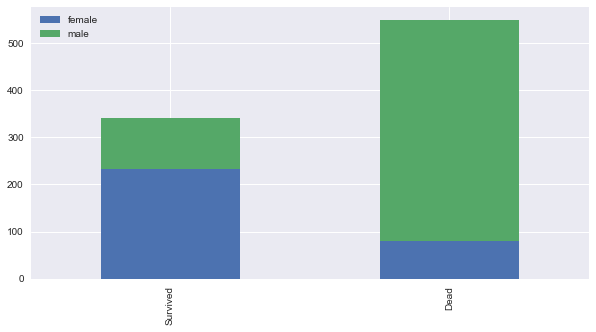

In [161]:
bar_chart('Sex')

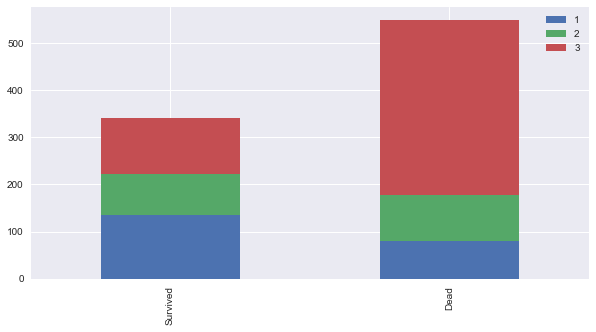

In [162]:
bar_chart('Pclass')

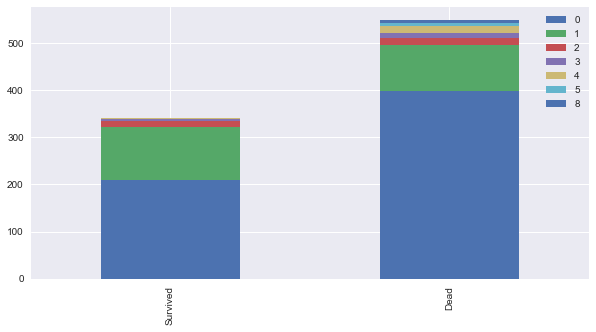

In [163]:
bar_chart('SibSp')

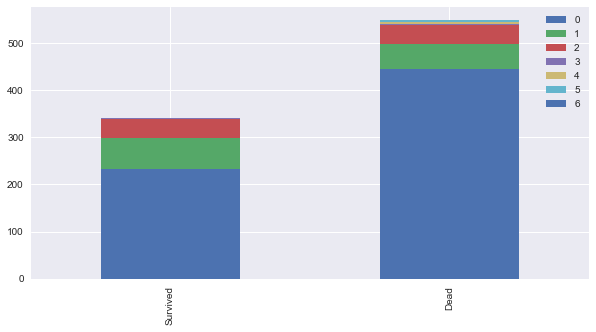

In [164]:
bar_chart('Parch')

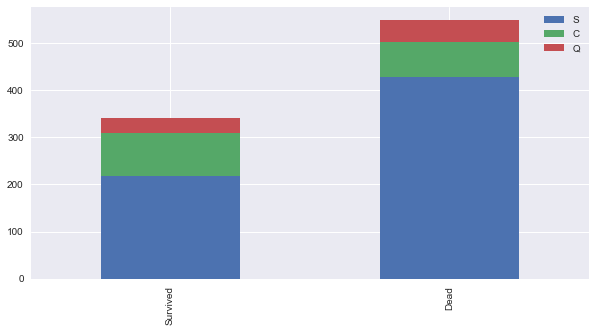

In [165]:
bar_chart('Embarked')

## 호칭(Title) 칼럼 추가
- 이름에서 공백+알파벳+온점 패턴 찾아서 알파벳 부분 추출
- 예시) Mr.Lee -> Mr

In [166]:
for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [167]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Capt          1
Don           1
Lady          1
Ms            1
Countess      1
Mme           1
Sir           1
Jonkheer      1
Name: Title, dtype: int64

## 호칭(Title) 숫자로 Mapping
- Mr : 0
- Miss : 1
- Mrs : 2
- Others : 3

In [168]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

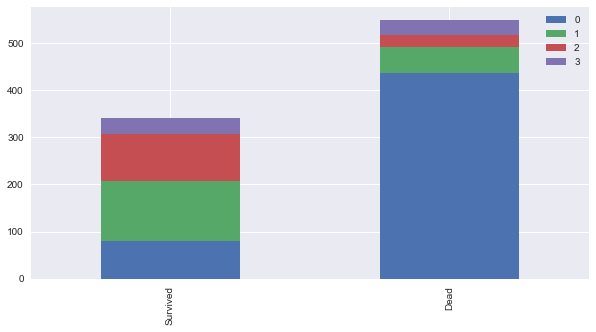

In [169]:
bar_chart('Title')

In [170]:
train.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Title  
0      0         A/5 21171   7.2500   NaN        S      0  
1      0          PC 17599  71.2833   C85        C      2  
2      0  STON/O2. 3101282   7.9250   NaN        S      1  
3      0            113803  53.1000  C123        S      2  
4      0            373450   8.0500   NaN        S      0

In [171]:
test.head(5)

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  Title  
0  34.5      0      0   330911   7.8292   NaN        Q      0  
1  47.0      1      0   363272   7.0000   NaN        S      2  
2  62.0      0      0   240276   9.6875   NaN        Q      0  
3  27.0      0      0   315154   8.6625   NaN        S      0  
4  22.0      1      1  3101298  12.2875   NaN        S      2

## FamilySize 칼럼 추가
- FamilySize = SibSp + Parch + 1

In [172]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

In [173]:
train.FamilySize.describe()

count    891.000000
mean       1.904602
std        1.613459
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: FamilySize, dtype: float64

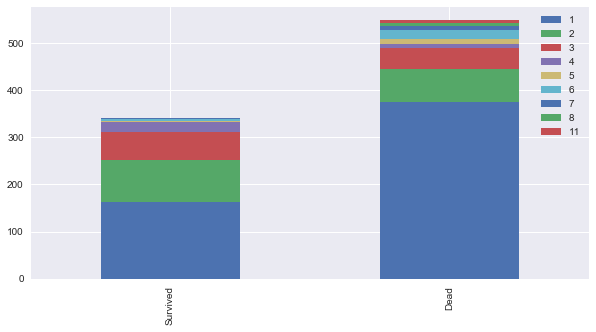

In [174]:
bar_chart('FamilySize')

(0, 11.0)

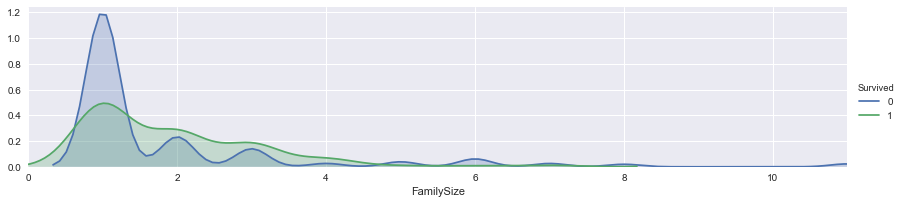

In [175]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'FamilySize',shade= True)
facet.set(xlim=(0, train['FamilySize'].max()))
facet.add_legend()
plt.xlim(0)

## 누락된 값이 있는 칼럼 확인
- Age
- Cabin
- Embarked
- Fare

In [176]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
FamilySize       0
dtype: int64

In [177]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
FamilySize       0
dtype: int64

## Age 누락된 값 채우기
- 동일 Title 그룹의 나이의 중위값(median)을 토대로 누락된 Age 추측
- 평균(mean) 대신 중위값(median)을 쓴 이유 : Outlier의 영향력을 줄이기 위해

In [178]:
print(train.groupby("Title").mean()["Age"])

Title
0    32.368090
1    21.773973
2    35.898148
3    20.430161
Name: Age, dtype: float64


In [179]:
print(train.groupby("Title").median()["Age"])

Title
0    30.0
1    21.0
2    35.0
3     9.0
Name: Age, dtype: float64


In [180]:
# 누락된 값 채우기 전의 모습 출력
train.loc[train.isnull()['Age'],:].head(5)

PassengerId  Survived  Pclass                           Name     Sex  Age  \
5             6         0       3               Moran, Mr. James    male  NaN   
17           18         1       2   Williams, Mr. Charles Eugene    male  NaN   
19           20         1       3        Masselmani, Mrs. Fatima  female  NaN   
26           27         0       3        Emir, Mr. Farred Chehab    male  NaN   
28           29         1       3  O'Dwyer, Miss. Ellen "Nellie"  female  NaN   

    SibSp  Parch  Ticket     Fare Cabin Embarked  Title  FamilySize  
5       0      0  330877   8.4583   NaN        Q      0           1  
17      0      0  244373  13.0000   NaN        S      0           1  
19      0      0    2649   7.2250   NaN        C      2           1  
26      0      0    2631   7.2250   NaN        C      0           1  
28      0      0  330959   7.8792   NaN        Q      1           1

In [181]:
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("median"), inplace=True)

In [182]:
# 채운 뒤 모습
train.query("PassengerId==6 | PassengerId==18 | PassengerId==20 | PassengerId==27 | PassengerId==29")

PassengerId  Survived  Pclass                           Name     Sex  \
5             6         0       3               Moran, Mr. James    male   
17           18         1       2   Williams, Mr. Charles Eugene    male   
19           20         1       3        Masselmani, Mrs. Fatima  female   
26           27         0       3        Emir, Mr. Farred Chehab    male   
28           29         1       3  O'Dwyer, Miss. Ellen "Nellie"  female   

     Age  SibSp  Parch  Ticket     Fare Cabin Embarked  Title  FamilySize  
5   30.0      0      0  330877   8.4583   NaN        Q      0           1  
17  30.0      0      0  244373  13.0000   NaN        S      0           1  
19  35.0      0      0    2649   7.2250   NaN        C      2           1  
26  30.0      0      0    2631   7.2250   NaN        C      0           1  
28  21.0      0      0  330959   7.8792   NaN        Q      1           1

## Cabin 값 정제
- 맨앞의 알파벳 하나만 추출

In [183]:
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]

## Cabin 숫자로 Mapping
- A : 0
- B : 0.4
- C : 0.8
- D : 1.2
- E : 1.6
- F : 2
- G : 2.4
- T : 2.8

In [184]:
cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

## Cabin 누락된 값 채우기
- 동일 Pclass 그룹 내 Cabin 값들의 Median 사용

In [185]:
# 누락된 값 채우기 전의 모습 출력
train.loc[train.isnull()['Cabin'],:].head(5)

PassengerId  Survived  Pclass                            Name     Sex  \
0            1         0       3         Braund, Mr. Owen Harris    male   
2            3         1       3          Heikkinen, Miss. Laina  female   
4            5         0       3        Allen, Mr. William Henry    male   
5            6         0       3                Moran, Mr. James    male   
7            8         0       3  Palsson, Master. Gosta Leonard    male   

    Age  SibSp  Parch            Ticket     Fare  Cabin Embarked  Title  \
0  22.0      1      0         A/5 21171   7.2500    NaN        S      0   
2  26.0      0      0  STON/O2. 3101282   7.9250    NaN        S      1   
4  35.0      0      0            373450   8.0500    NaN        S      0   
5  30.0      0      0            330877   8.4583    NaN        Q      0   
7   2.0      3      1            349909  21.0750    NaN        S      3   

   FamilySize  
0           2  
2           1  
4           1  
5           1  
7           5

In [186]:
train["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
test["Cabin"].fillna(test.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

In [187]:
train.query("PassengerId==1 | PassengerId==3 | PassengerId==5 | PassengerId==6 | PassengerId==8")

PassengerId  Survived  Pclass                            Name     Sex  \
0            1         0       3         Braund, Mr. Owen Harris    male   
2            3         1       3          Heikkinen, Miss. Laina  female   
4            5         0       3        Allen, Mr. William Henry    male   
5            6         0       3                Moran, Mr. James    male   
7            8         0       3  Palsson, Master. Gosta Leonard    male   

    Age  SibSp  Parch            Ticket     Fare  Cabin Embarked  Title  \
0  22.0      1      0         A/5 21171   7.2500    2.0        S      0   
2  26.0      0      0  STON/O2. 3101282   7.9250    2.0        S      1   
4  35.0      0      0            373450   8.0500    2.0        S      0   
5  30.0      0      0            330877   8.4583    2.0        Q      0   
7   2.0      3      1            349909  21.0750    2.0        S      3   

   FamilySize  
0           2  
2           1  
4           1  
5           1  
7           5

## Embarked 누락된 값 채우기
- 모집단의 Embarked의 최빈값(S) 사용

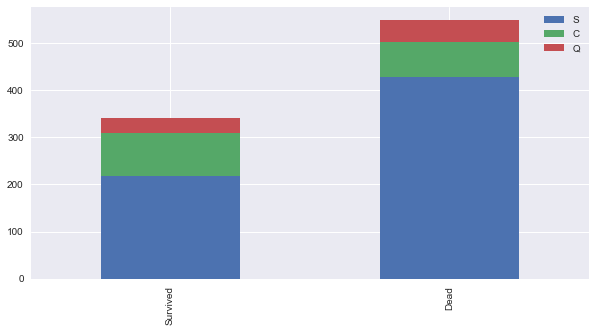

In [188]:
bar_chart('Embarked')

In [189]:
train.loc[train.isnull()['Embarked'],:].head()

PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare  Cabin Embarked  Title  \
61   female  38.0      0      0  113572  80.0    0.4      NaN      1   
829  female  62.0      0      0  113572  80.0    0.4      NaN      2   

     FamilySize  
61            1  
829           1

In [190]:
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [191]:
train.query("PassengerId==62 | PassengerId==830")

PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare  Cabin Embarked  Title  \
61   female  38.0      0      0  113572  80.0    0.4        S      1   
829  female  62.0      0      0  113572  80.0    0.4        S      2   

     FamilySize  
61            1  
829           1

##  Fare 누락된 값 채우기
- 누락된 Fare값을 같은 좌석 등급(Pclass)의 Fare 중위값으로 채운다.
- 현재 train에는 Fare가 누락된 행이 없으며, test에 하나의 행의 Fare가 누락되어 있다.
- Pclass(좌석 등급) 기준으로 groupby 수행해서 그룹의 중위값으로 누락된 Fare를 채울 것임

In [192]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Title          0
FamilySize     0
dtype: int64

In [193]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin          0
Embarked       0
Title          0
FamilySize     0
dtype: int64

In [194]:
test.loc[test.isnull()['Fare'],:].head()

PassengerId  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

     Fare  Cabin Embarked  Title  FamilySize  
152   NaN    2.0        S      0           1

In [195]:
train["Fare"].fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace=True)
test["Fare"].fillna(test.groupby("Pclass")["Fare"].transform("median"), inplace=True)

In [196]:
test.query("PassengerId==1044")

PassengerId  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

       Fare  Cabin Embarked  Title  FamilySize  
152  7.8958    2.0        S      0           1

## 성별 숫자로 Mapping
- male : 0
- female : 1

In [197]:
sex_mapping = {"male": 0, "female": 1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

## Embarked 숫자로 Mapping

In [198]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

## Fare 카테고리로 Mapping
- 0 ~ 17 : 0
- 18 ~ 30 : 1
- 31 ~ 100 : 2
- 101 ~ : 3

In [199]:
train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [200]:
test.Fare.describe()

count    418.000000
mean      35.560845
std       55.856972
min        0.000000
25%        7.895800
50%       14.454200
75%       31.471875
max      512.329200
Name: Fare, dtype: float64

In [201]:
for dataset in train_test_data:
    dataset.loc[ dataset['Fare'] <= 17, 'Fare'] = 0,
    dataset.loc[(dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1,
    dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2,
    dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3

In [202]:
print(train['Fare'].value_counts())

0.0    496
2.0    181
1.0    161
3.0     53
Name: Fare, dtype: int64


In [203]:
print(test['Fare'].value_counts())

0.0    236
2.0     78
1.0     73
3.0     31
Name: Fare, dtype: int64


## Age 카테고리로 Mapping
- ~ 16 : 0
- 17 ~ 26 : 1
- 27 ~ 36 : 2
- 37 ~ 62 : 3
- 63 ~ : 4

In [204]:
train.Age.describe()

count    891.000000
mean      29.372806
std       13.227346
min        0.420000
25%       21.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [205]:
test.Age.describe()

count    418.000000
mean      29.660287
std       12.955328
min        0.170000
25%       22.000000
50%       28.500000
75%       36.500000
max       76.000000
Name: Age, dtype: float64

In [206]:
for dataset in train_test_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0,
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 1,
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 36), 'Age'] = 2,
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 62), 'Age'] = 3,
    dataset.loc[ dataset['Age'] > 62, 'Age'] = 4

In [207]:
print(train['Age'].value_counts())

2.0    336
1.0    255
3.0    180
0.0    105
4.0     15
Name: Age, dtype: int64


In [208]:
print(test['Age'].value_counts())

2.0    139
1.0    134
3.0     99
0.0     39
4.0      7
Name: Age, dtype: int64


In [209]:
train.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex  Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  1.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  3.0      1      0   
2                             Heikkinen, Miss. Laina    1  1.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  2.0      1      0   
4                           Allen, Mr. William Henry    0  2.0      0      0   

             Ticket  Fare  Cabin  Embarked  Title  FamilySize  
0         A/5 21171   0.0    2.0         0      0           2  
1          PC 17599   2.0    0.8         1      2           2  
2  STON/O2. 3101282   0.0    2.0         0      1           1  
3            113803   2.0    0.8         0      2           2  
4            373450   0.0    2.0         0      0           1

## 불필요한 칼럼 제거하기
- Name
- Ticket
- SibSp
- Parch
- SibSp와 Parch는 FamilySize에 반영돼있으니 빼도 무방할 것으로 여겨짐

In [210]:
features_drop = ['Name', 'Ticket', 'SibSp', 'Parch']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
train = train.drop(['PassengerId'], axis=1)

In [211]:
train.head(5)

Survived  Pclass  Sex  Age  Fare  Cabin  Embarked  Title  FamilySize
0         0       3    0  1.0   0.0    2.0         0      0           2
1         1       1    1  3.0   2.0    0.8         1      2           2
2         1       3    1  1.0   0.0    2.0         0      1           1
3         1       1    1  2.0   2.0    0.8         0      2           2
4         0       3    0  2.0   0.0    2.0         0      0           1

In [212]:
test.head(5)

PassengerId  Pclass  Sex  Age  Fare  Cabin  Embarked  Title  FamilySize
0          892       3    0  2.0   0.0    2.0         2      0           1
1          893       3    1  3.0   0.0    2.0         0      2           2
2          894       2    0  3.0   0.0    2.0         2      0           1
3          895       3    0  2.0   0.0    2.0         0      0           1
4          896       3    1  1.0   0.0    2.0         0      2           3

## Train 데이터에서 True Y 값 추출
- 정제가 완료된 train 데이터에서 Survived 칼럼의 값을 빼서 y_train에 저장

In [213]:
x_train = train.drop('Survived', axis=1)
x_train.shape

(891, 8)

In [214]:
x_train.head(5)

Pclass  Sex  Age  Fare  Cabin  Embarked  Title  FamilySize
0       3    0  1.0   0.0    2.0         0      0           2
1       1    1  3.0   2.0    0.8         1      2           2
2       3    1  1.0   0.0    2.0         0      1           1
3       1    1  2.0   2.0    0.8         0      2           2
4       3    0  2.0   0.0    2.0         0      0           1

In [215]:
y_train = train['Survived']
y_train.shape

(891,)

In [216]:
y_train.head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## True Y 값을 One Hot Vector 형식으로 변경
- softmax 분류기에서 cost 계산을 위해선 One Hot Vector 형식의 y_train 값을 넣어줘야 하기 때문

In [218]:
y_train = to_categorical(train['Survived'])
y_train.shape

(891, 2)

## 모델링

In [219]:
model = Sequential()
model.add(Dense(units=8,
                input_dim=x_train.shape[1],
                activation='relu'))

model.add(Dense(units=2,
                activation='softmax'))

adadelta = keras.optimizers.Adadelta()

model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['accuracy'])

In [222]:
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
891/891 [==============================] - 0s 19us/step - loss: 0.3923 - acc: 0.8418
Epoch 2/100
891/891 [==============================] - 0s 17us/step - loss: 0.3932 - acc: 0.8373
Epoch 3/100
891/891 [==============================] - 0s 17us/step - loss: 0.3925 - acc: 0.8406
Epoch 4/100
891/891 [==============================] - 0s 22us/step - loss: 0.3928 - acc: 0.8373
Epoch 5/100
891/891 [==============================] - 0s 20us/step - loss: 0.3923 - acc: 0.8373
Epoch 6/100
891/891 [==============================] - 0s 21us/step - loss: 0.3921 - acc: 0.8373
Epoch 7/100
891/891 [==============================] - 0s 24us/step - loss: 0.3919 - acc: 0.8373
Epoch 8/100
891/891 [==============================] - 0s 20us/step - loss: 0.3929 - acc: 0.8350
Epoch 9/100
891/891 [==============================] - 0s 20us/step - loss: 0.3918 - acc: 0.8384
Epoch 10/100
891/891 [==============================] - 0s 19us/step - loss: 0.3920 - acc: 0.8350
Epoch 11/100
891/891 [=======

## Test 데이터 예측

In [223]:
x_test = test
x_test.shape

(418, 9)

In [224]:
x_test.head(5)

PassengerId  Pclass  Sex  Age  Fare  Cabin  Embarked  Title  FamilySize
0          892       3    0  2.0   0.0    2.0         2      0           1
1          893       3    1  3.0   0.0    2.0         0      2           2
2          894       2    0  3.0   0.0    2.0         2      0           1
3          895       3    0  2.0   0.0    2.0         0      0           1
4          896       3    1  1.0   0.0    2.0         0      2           3

In [225]:
y_pred = model.predict_classes(x_test.drop('PassengerId',axis=1).values)

In [226]:
y_pred.shape

(418,)

In [227]:
y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [228]:
submission = pd.DataFrame()
submission['PassengerId'] = x_test.index+892
submission['Survived'] = y_pred

In [229]:
submission.shape

(418, 2)

In [230]:
submission.head(5)

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [231]:
submission.to_csv('titanic_keras.csv', index=False)